# DSE Project - Visual Product Recognition - Data Analysis

The followings are some of the datasets available for training our model for visual product recognition
1. Product-10k [link](https://products-10k.github.io/)
2. H&M [link](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data)
3. Amazon Dataset [link](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/)
4. Shopee [link](https://www.kaggle.com/competitions/shopee-product-matching/data)

A part of the testing dataset for visual product recognition challenge can be accessed from this [link](https://www.aicrowd.com/challenges/visual-product-recognition-challenge-2023/dataset_files)



## Downloading the Product-10k training dataset and extracting the archive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%capture
!unzip /content/gdrive/MyDrive/archive.zip -d /content/training-dataset/

In [ ]:
!mv "/content/training-dataset/train/train" "/content/"
!mv "/content/training-dataset/test/test" "/content/"

!rmdir "/content/training-dataset/train"
!rmdir "/content/training-dataset/test"

!mv "/content/train" "/content/training-dataset/"
!mv "/content/test" "/content/training-dataset/"

### Other training datasets

In [ ]:
# Code to download the amazon dataset and saving it in the google drive

# !wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles/All_Amazon_Meta.json.gz
# !cp "/content/All_Amazon_Meta.json.gz" "/content/gdrive/MyDrive/"

## Downloading the test dataset by Aicrowd and extracting the archive

In [2]:
%%capture
!unzip /content/gdrive/MyDrive/test-archive.zip -d /content/testing-dataset

In [3]:
!mv "/content/testing-dataset/development_test_data/gallery" "/content/"
!mv "/content/testing-dataset/development_test_data/queries/" "/content/"
!mv "/content/testing-dataset/development_test_data/gallery.csv" "/content/"
!mv "/content/testing-dataset/development_test_data/queries.csv" "/content/"

!rmdir "/content/testing-dataset/development_test_data"

!mv "/content/gallery" "/content/testing-dataset/"
!mv "/content/queries" "/content/testing-dataset/"
!mv "/content/gallery.csv" "/content/testing-dataset/"
!mv "/content/queries.csv" "/content/testing-dataset/"

## Import necessary modules

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from pathlib import Path
from sklearn.cluster import KMeans

## Helper functions

In [5]:
def get_img(img_path):
  """
  This function returns an image in the format RGB when the path
  to the image is given

  Parameters
  ----------
  img_path: string
      The path to the image

  Returns
  -------
  RGB image of the image in the specified path
  """
  return cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

def view_and_get_info_random_image(folder):
  """
  This function takes a path of a folder that contains images and
  display a random image from that folder along with its shape

  Parameters
  ----------
  folder: string
      The path of the folder with pictures (all the files within that folder should be images)

  Return
  ------
  The rendered random image
  """
  # Get a random image path
  random_image = random.sample(os.listdir(folder), 1)

  # Read in the image and plot it using matplotlib
  img = get_img(folder + random_image[0])
  plt.imshow(img)
  plt.title(folder + random_image[0])
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

def draw_bounding_box_and_save(img_path, x, y, w, h):
  """
  This function draw a bounding box specified by x, y, w, h parameters
  and save the image in the '/content/temp-imgs/' folder

  Parameters
  ----------
  img_path: string
      The path to original image which the bounding box should be drawn
  x: integer
      x-coordinate of top-left corner of bounding box
  y: integer
      y-coordinate of top-left corner of bounding box
  w: integer
      width of bounding box in pixels
  h: integer
      height of bounding box in pixels
  """
  image = get_img(img_path)
  cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,255), 4)

  Path("/content/temp-imgs").mkdir(parents=True, exist_ok=True)

  filepath = '/content/temp-imgs/' + img_path.split('/')[-1]
  cv2.imwrite(filepath, image)
  return filepath

## Analyzing the training dataset
```
File and folder structure of Product-10K dataset

training-dataset
└───train
│   |   1.jpg
│   |   2.jpg
│   |   3.jpg
│   |   4.jpg
│   
└───test
|   |   3963142.jpg
|   |   1209854.jpg
|   |   8638678.jpg
|   |   6997109.jpg
|
└───train.csv
|
└───test.csv
```

In [ ]:
training_dataset_train = pd.read_csv('training-dataset/train.csv', low_memory=False)
training_dataset_test = pd.read_csv('training-dataset/test.csv', low_memory=False)

print('train.csv\n==========')
print('shape:', training_dataset_train.shape)
print('number of null values:', training_dataset_train.isnull().sum().sum())
print('number of duplicated rows:', training_dataset_train.duplicated().sum())
print('number of duplicated images:', training_dataset_train['name'].duplicated().sum())
display(training_dataset_train.head())

print('\ntest.csv\n=========')
print('shape:', training_dataset_test.shape)
print('number of null values:', training_dataset_test.isnull().sum().sum())
print('number of duplicated rows:', training_dataset_test.duplicated().sum())
print('number of duplicated images:', training_dataset_test['name'].duplicated().sum())
display(training_dataset_test.head())

train.csv
shape: (141931, 3)
number of null values: 0
number of duplicated rows: 0
number of duplicated images: 0


name  class  group
0  1.jpg      0      0
1  2.jpg      0      0
2  3.jpg      0      0
3  4.jpg      0      0
4  5.jpg      0      0


test.csv
shape: (55376, 2)
number of null values: 0
number of duplicated rows: 0
number of duplicated images: 0


name  class
0  3963142.jpg      0
1  1209854.jpg      0
2  8638678.jpg      0
3  6997109.jpg      0
4  3134887.jpg      0

In [ ]:
train_test_concat = pd.concat([training_dataset_train[['name', 'class']], training_dataset_test])
display(train_test_concat.head())
print('shape:', train_test_concat.shape)
print('number of null values:', train_test_concat.isnull().sum().sum())
print('number of duplicated rows:', train_test_concat.duplicated().sum())
print('number of duplicated images:', train_test_concat['name'].duplicated().sum())

name  class
0  1.jpg      0
1  2.jpg      0
2  3.jpg      0
3  4.jpg      0
4  5.jpg      0

shape: (197307, 2)
number of null values: 0
number of duplicated rows: 0
number of duplicated images: 0


Image shape: (2208, 1656, 3)


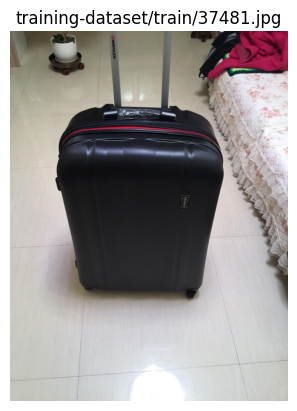

In [ ]:
img = view_and_get_info_random_image('training-dataset/train/')

Image shape: (918, 1632, 3)


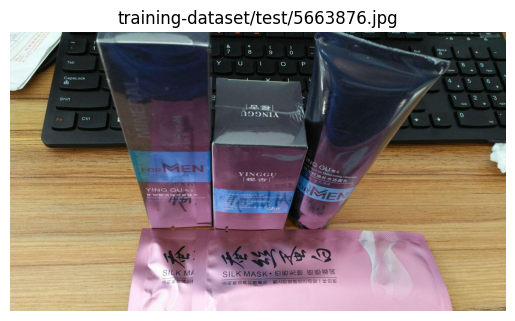

In [ ]:
img = view_and_get_info_random_image('training-dataset/test/')

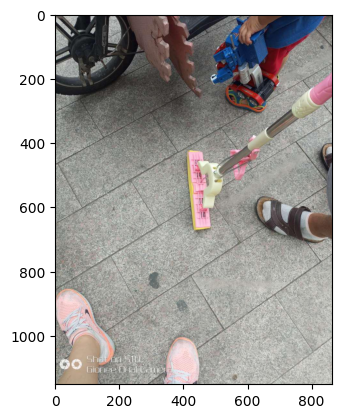

In [ ]:
img = get_img('/content/training-dataset/test/9397815.jpg')
plt.imshow(img)
plt.show()

In [ ]:
count_of_classes_train = (training_dataset_train[['group', 'class']]).groupby(['group', 'class']).size()
count_of_classes_test = (training_dataset_test[['class']]).groupby('class').size()
count_of_classes_concat = (train_test_concat[['class']]).groupby('class').size()

count_of_classes_train = pd.DataFrame(count_of_classes_train)
count_of_classes_train = count_of_classes_train.reset_index()
count_of_classes_train.columns = ['group', 'class', '# of images']
print('The shape of class categories of training_dataset_train is', count_of_classes_train.shape)
print('The number of unique groups is', count_of_classes_train['group'].nunique())
display(count_of_classes_train.head())

count_of_classes_test = pd.DataFrame(count_of_classes_test)
count_of_classes_test = count_of_classes_test.reset_index()
count_of_classes_test.columns = ['class', '# of images']
print('\nThe shape of class categories of training_dataset_test is', count_of_classes_test.shape)
display(count_of_classes_test.head())

count_of_classes_train_test = pd.DataFrame(count_of_classes_concat)
count_of_classes_train_test = count_of_classes_train_test.reset_index()
count_of_classes_train_test.columns = ['class', '# of images']
print('\nThe shape of class categories of training_dataset_train_test is', count_of_classes_train_test.shape)
display(count_of_classes_train_test.head())

The shape of class categories of training_dataset_train is (9691, 3)
The number of unique groups is 360


group  class  # of images
0      0      0           16
1      0     13           11
2      0     19           18
3      0     22            7
4      0     23            3


The shape of class categories of training_dataset_test is (9691, 2)


class  # of images
0      0            6
1      1            3
2      2            6
3      3            6
4      4            6


The shape of class categories of training_dataset_train_test is (9691, 2)


class  # of images
0      0           22
1      1            5
2      2           10
3      3           13
4      4           12

In [ ]:
print('\ntrain.csv\n==============')
print('minimum number of images in a class:', count_of_classes_train['# of images'].min())
print('maximum number of images in a class:', count_of_classes_train['# of images'].max())
print('mode of number of images in a class:', count_of_classes_train['# of images'].mode().tolist())
print('median of number of images ina a class:', count_of_classes_train['# of images'].median())
print('number of images in the dataset', count_of_classes_train['# of images'].sum())

print('\ntest.csv\n==============')
print('minimum number of images in a class:', count_of_classes_test['# of images'].min())
print('maximum number of images in a class:', count_of_classes_test['# of images'].max())
print('mode of number of images in a class:', count_of_classes_test['# of images'].mode().tolist())
print('median of number of images ina a class:', count_of_classes_test['# of images'].median())
print('number of images in the dataset', count_of_classes_test['# of images'].sum())

print('\ntrain test concat\n==============')
print('minimum number of images in a class:', count_of_classes_train_test['# of images'].min())
print('maximum number of images in a class:', count_of_classes_train_test['# of images'].max())
print('mode of number of images in a class:', count_of_classes_train_test['# of images'].mode().tolist())
print('median of number of images ina a class:', count_of_classes_train_test['# of images'].median())
print('number of images in the dataset', count_of_classes_train_test['# of images'].sum())


train.csv
minimum number of images in a class: 2
maximum number of images in a class: 81
mode of number of images in a class: [4]
median of number of images ina a class: 12.0
number of images in the dataset 141931

test.csv
minimum number of images in a class: 3
maximum number of images in a class: 6
mode of number of images in a class: [6]
median of number of images ina a class: 6.0
number of images in the dataset 55376

train test concat
minimum number of images in a class: 5
maximum number of images in a class: 87
mode of number of images in a class: [11]
median of number of images ina a class: 18.0
number of images in the dataset 197307


In [ ]:
def graph_the_list_of_images(img_paths, path_prefix, random_sample, class_=True):
  num_images = len(img_paths)
  num_rows = np.ceil((num_images / 5))
  fig, axis = plt.subplots(int(num_rows), 5, figsize=(20, int(num_rows * 4)))
  index = 0
  index_limit = 4
  column = 0
  row = 0
  while index < (num_rows * 5):
    if index < len(img_paths):
      if num_rows > 1:
        axis[row, column].imshow(get_img(path_prefix + img_paths[index]))
        axis[row, column].axis("off")
      else:
        axis[column].imshow(get_img(path_prefix + img_paths[index]))
        axis[column].axis("off")
    if num_rows > 1:
      axis[row, column].axis("off")
    else:
      axis[column].axis("off")

    index = index + 1
    column = column + 1

    if index > index_limit:
      index_limit = index_limit + 5
      row = row + 1
      column = 0

  if class_:
    fig.suptitle('Random images of ' + path_prefix + ' for class=' + str(random_sample[0]))
  else:
    fig.suptitle('Random images of ' + path_prefix + ' for group=' + str(random_sample[0]))
  plt.show()


def view_images_of_random_class_or_group(dataset, path_prefix, class_=True):
  if class_:
    list_of_classes = dataset['class'].tolist()
    random_sample = random.sample(list_of_classes, 1)
  else:
    list_of_groups = dataset['group'].tolist()
    random_sample = random.sample(list_of_groups, 1)
  img_paths = (dataset.loc[dataset['class'] == random_sample[0]])['name'].tolist()
  if len(img_paths) > 20:
    img_paths = random.sample(img_paths, 20)
  graph_the_list_of_images(img_paths, path_prefix, random_sample, class_)

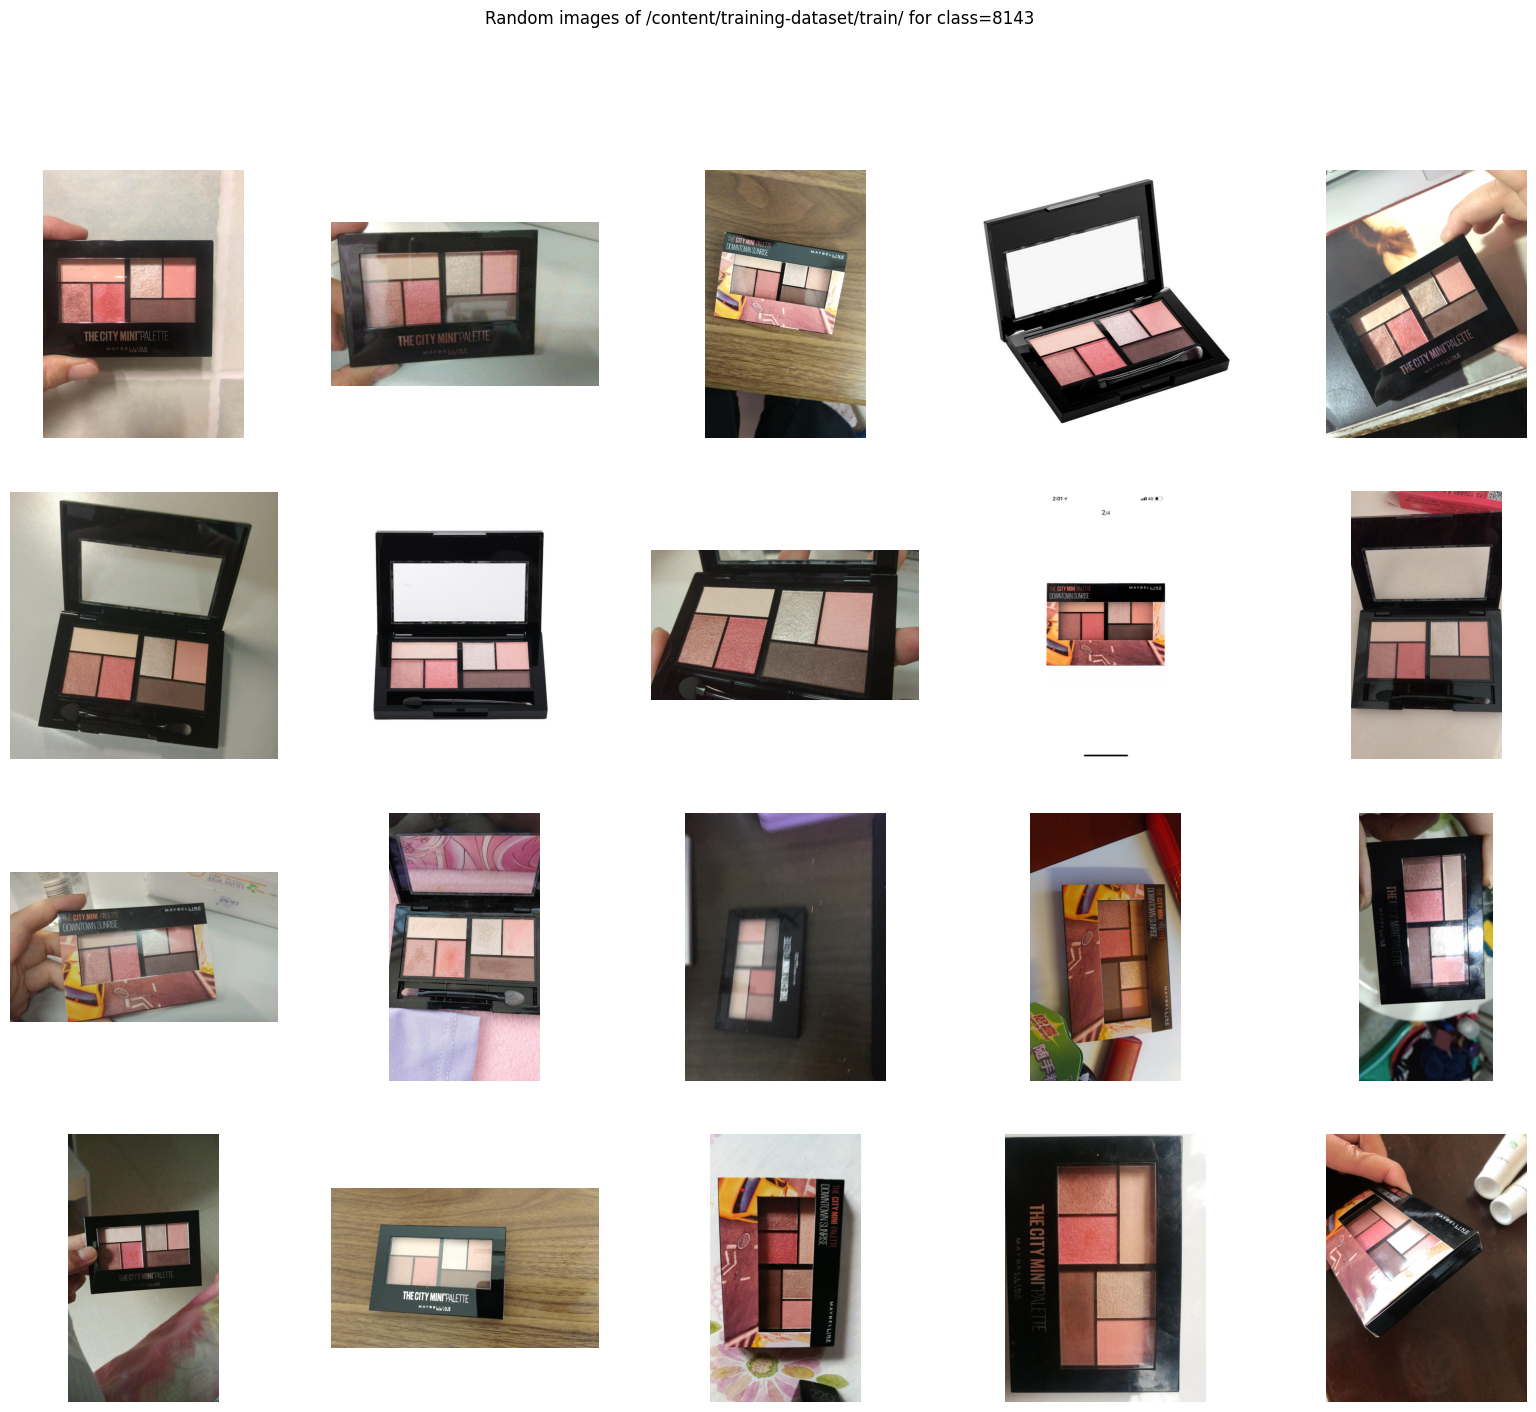

In [ ]:
view_images_of_random_class_or_group(training_dataset_train, '/content/training-dataset/train/', True)

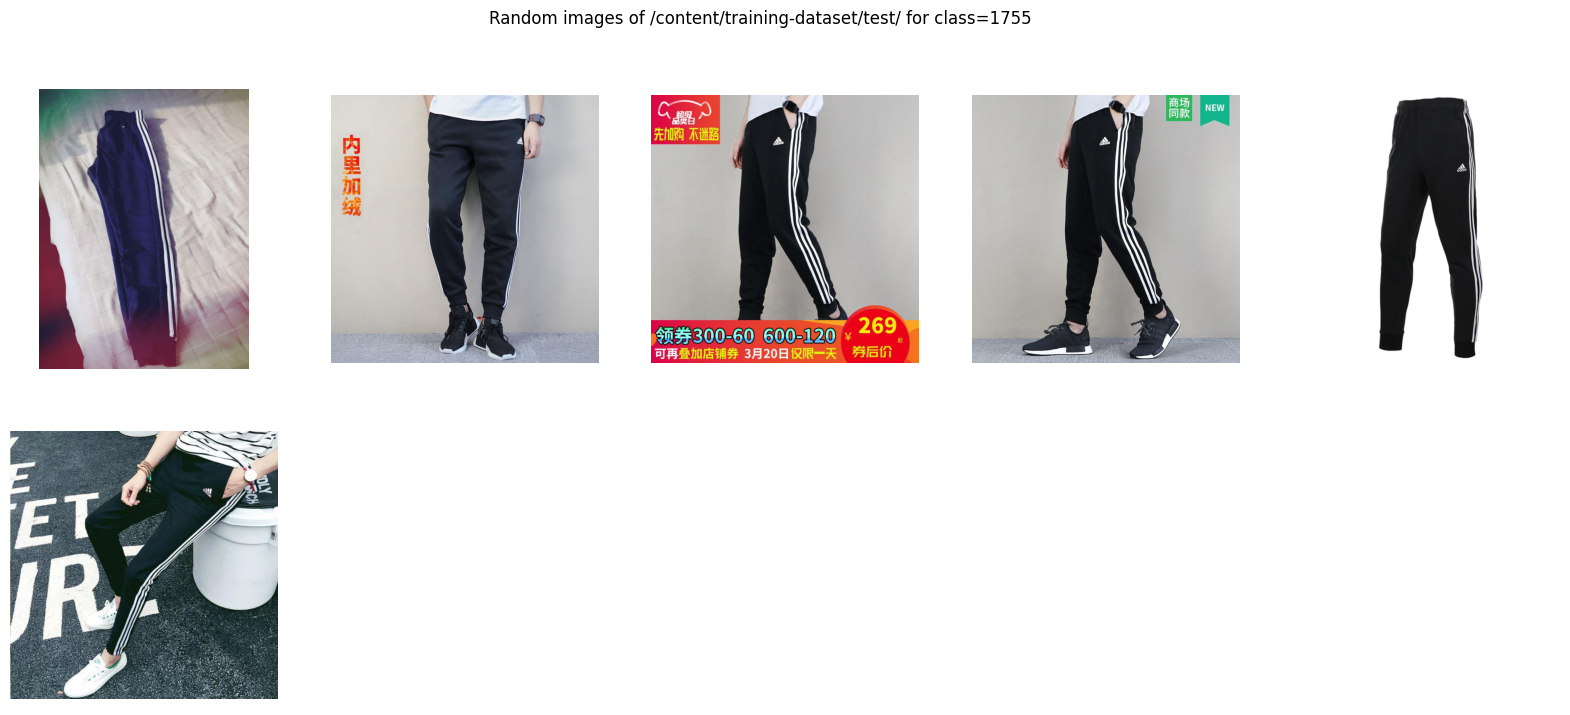

In [ ]:
view_images_of_random_class_or_group(training_dataset_test, '/content/training-dataset/test/', True)

In [ ]:
def get_image_shapes_of_train_and_test_images():
  list_of_shapes_train = []
  list_of_shapes_test = []
  for train_image_path in training_dataset_train['name'].tolist():
    list_of_shapes_train.append((get_img('/content/training-dataset/train/' + train_image_path)).shape)

  for test_image_path in training_dataset_test['name'].tolist():
    list_of_shapes_test.append((get_img('/content/training-dataset/test/' + test_image_path)).shape)

  return pd.DataFrame(list_of_shapes_train, columns=['height', 'width', 'channels']), pd.DataFrame(list_of_shapes_test, columns=['height', 'width', 'channels'])

In [ ]:
train_image_shapes, test_image_shapes = get_image_shapes_of_train_and_test_images()

In [ ]:
train_image_shapes.insert(2, "aspect_ratio", np.round(train_image_shapes['width'] / train_image_shapes['height'], decimals=2), True)
test_image_shapes.insert(2, "aspect_ratio", np.round(test_image_shapes['width'] / test_image_shapes['height'], decimals=2), True)

print('train.csv images')
display(train_image_shapes.head())
print('\test.csv images')
display(test_image_shapes.head())

train.csv images


height  width  aspect_ratio  channels
0     800    800          1.00         3
1     749    562          0.75         3
2     800    800          1.00         3
3    1280    960          0.75         3
4     800    800          1.00         3

	est.csv images


height  width  aspect_ratio  channels
0     800    800           1.0         3
1     800    800           1.0         3
2     800    800           1.0         3
3     800    800           1.0         3
4     800    800           1.0         3

<Axes: title={'center': 'aspect_ratio(train)'}, ylabel='Density'>

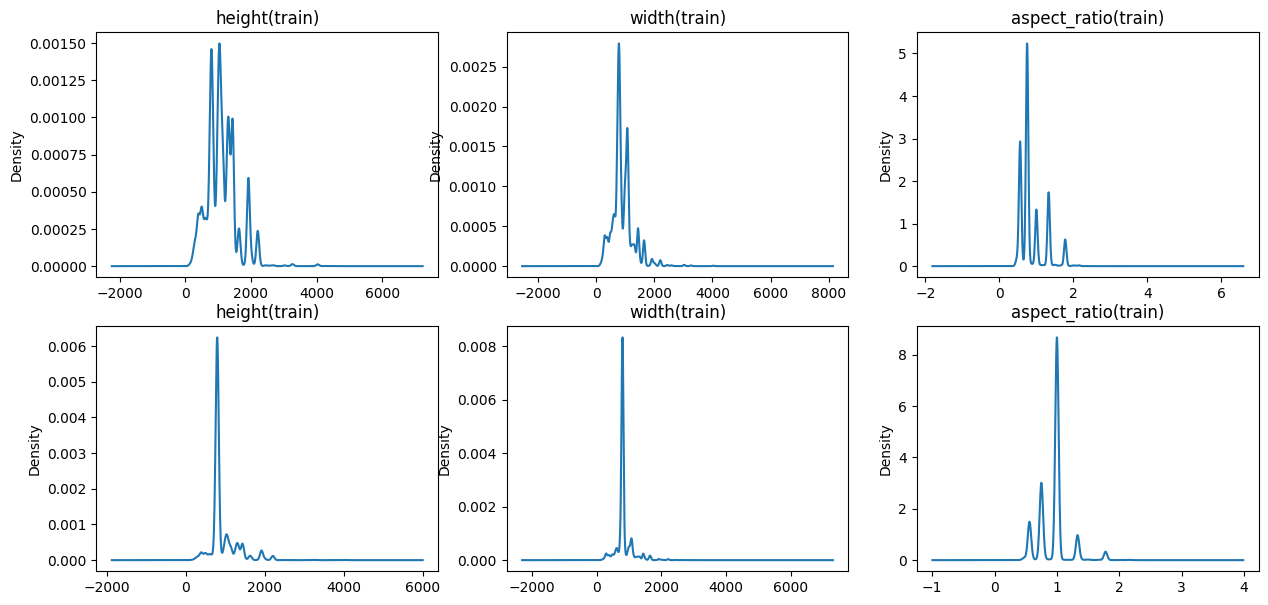

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

train_image_shapes['height'].plot(kind='density', ax=axes[0, 0], title='height(train)')
train_image_shapes['width'].plot(kind='density', ax=axes[0, 1], title='width(train)')
train_image_shapes['aspect_ratio'].plot(kind='density', ax=axes[0, 2], title='aspect_ratio(train)')

test_image_shapes['height'].plot(kind='density', ax=axes[1, 0], title='height(train)')
test_image_shapes['width'].plot(kind='density', ax=axes[1, 1], title='width(train)')
test_image_shapes['aspect_ratio'].plot(kind='density', ax=axes[1, 2], title='aspect_ratio(train)')

<Axes: title={'center': 'aspect_ratio(pooled)'}, ylabel='Density'>

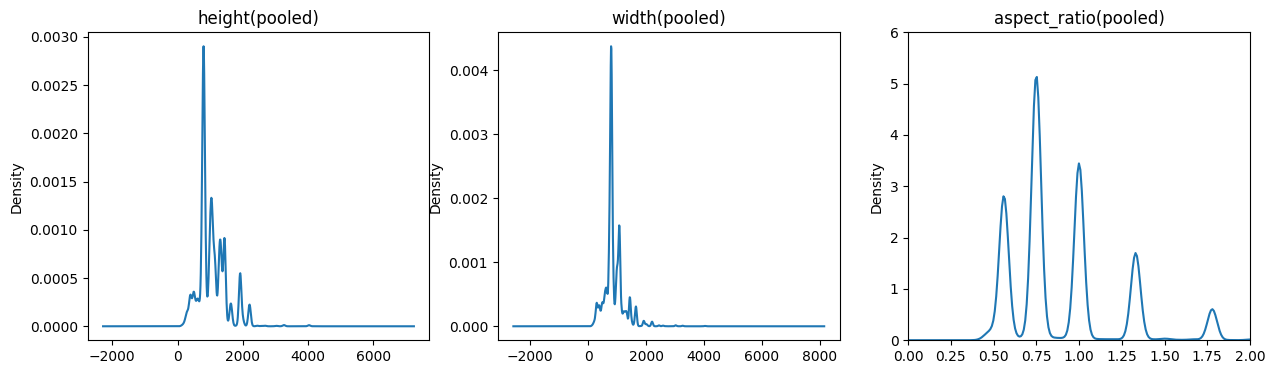

In [ ]:
train_test_image_shapes = pd.concat([train_image_shapes[['height', 'width', 'aspect_ratio']], test_image_shapes[['height', 'width', 'aspect_ratio']]], axis=0)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
train_test_image_shapes['height'].plot(kind='density', ax=axes[0], title='height(pooled)')
train_test_image_shapes['width'].plot(kind='density', ax=axes[1], title='width(pooled)')
plt.axis([0, 2, 0, 6])
train_test_image_shapes['aspect_ratio'].plot(kind='density', ax=axes[2], title='aspect_ratio(pooled)')

In [ ]:
#################################################################
print('train.csv\n============')
mode = train_image_shapes['height'].mode().tolist()
median = train_image_shapes['height'].median()
mean = train_image_shapes['height'].mean()
print(f'height -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = train_image_shapes['width'].mode().tolist()
median = train_image_shapes['width'].median()
mean = train_image_shapes['width'].mean()
print(f'width -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = train_image_shapes['aspect_ratio'].mode().tolist()
median = train_image_shapes['aspect_ratio'].median()
mean = train_image_shapes['aspect_ratio'].mean()
print(f'aspect_ratio -> mode: {mode}, median: {median}, mean: {np.round(mean, decimals=2)}')
##################################################################
print('\ntest.csv\n============')
mode = test_image_shapes['height'].mode().tolist()
median = test_image_shapes['height'].median()
mean = test_image_shapes['height'].mean()
print(f'height -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = test_image_shapes['width'].mode().tolist()
median = test_image_shapes['width'].median()
mean = test_image_shapes['width'].mean()
print(f'width -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = test_image_shapes['aspect_ratio'].mode().tolist()
median = test_image_shapes['aspect_ratio'].median()
mean = test_image_shapes['aspect_ratio'].mean()
print(f'aspect_ratio -> mode: {mode}, median: {median}, mean: {np.round(mean, decimals=2)}')
###################################################################
print('\nPooled\n===============')
mode = train_test_image_shapes['height'].mode().tolist()
median = train_test_image_shapes['height'].median()
mean = train_test_image_shapes['height'].mean()
print(f'height -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = train_test_image_shapes['width'].mode().tolist()
median = train_test_image_shapes['width'].median()
mean = train_test_image_shapes['width'].mean()
print(f'width -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = train_test_image_shapes['aspect_ratio'].mode().tolist()
median = train_test_image_shapes['aspect_ratio'].median()
mean = train_test_image_shapes['aspect_ratio'].mean()
print(f'aspect_ratio -> mode: {mode}, median: {median}, mean: {np.round(mean, decimals=2)}')

train.csv
height -> mode: [1440], median: 1048.0, mean: 1114.0
width -> mode: [1080], median: 810.0, mean: 908.0
aspect_ratio -> mode: [0.75], median: 0.75, mean: 0.88

test.csv
height -> mode: [800], median: 800.0, mean: 935.0
width -> mode: [800], median: 800.0, mean: 844.0
aspect_ratio -> mode: [1.0], median: 1.0, mean: 0.94

Pooled
height -> mode: [800], median: 1000.0, mean: 1064.0
width -> mode: [800], median: 800.0, mean: 890.0
aspect_ratio -> mode: [0.75], median: 0.75, mean: 0.89


In [ ]:
train_test_image_shapes.drop(['aspect_ratio'],axis=1, inplace = True)
display(train_test_image_shapes)

height  width
0         800    800
1         749    562
2         800    800
3        1280    960
4         800    800
...       ...    ...
55371     800    800
55372     800    800
55373     800    800
55374     800    800
55375     800    800

[197307 rows x 2 columns]

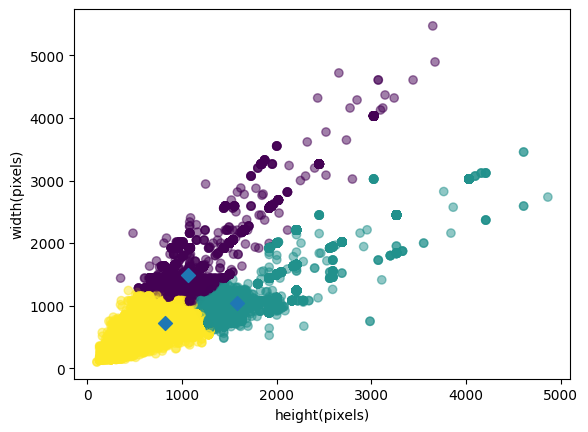

In [ ]:
model = KMeans(n_clusters=3, n_init='auto', random_state=42)

data_points = train_test_image_shapes.to_numpy()

model.fit(data_points)

labels = model.predict(data_points)

xs = data_points[:,0]
ys = data_points[:,1]
plt.scatter(xs,ys,c=labels,alpha=0.5)

centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.xlabel('height(pixels)')
plt.ylabel('width(pixels)')
plt.show()

In [ ]:
print(centroids)
print('\nThe corresponding aspect ratios for the centroids are,')
print(centroids[0][0] / centroids[0][1])
print(centroids[1][0] / centroids[1][1])
print(centroids[2][0] / centroids[2][1])

[[1056.94182373 1484.94435085]
 [1580.29740311 1035.87384578]
 [ 818.29415374  726.92695083]]

The corresponding aspect ratios for the centroids are,
0.7117720089176379
1.5255693630565845
1.12568966223499


## Analyzing the testing dataset

```
File and folder structure of the test dataset

testing-dataset
└───gallery
│   |   ambitious-tough-teal-from-asgard.jpg
│   |   fine-shrewd-oarfish-of-genius.jpg
│   |   bold-nickel-gecko-of-reputation.jpg
│   |   marvellous-uber-boobook-of-lightning.jpg
│   
└───queries
|   |   ambitious-tough-teal-from-asgard.jpeg
|   |   free-keen-mole-of-cookies.jpeg
|   |   optimal-uptight-ringtail-of-cleaning.jpeg
|
└───gallery.csv
|
└───queries.csv
```

In [6]:
testing_dataset_gallery = pd.read_csv('testing-dataset/gallery.csv')
testing_dataset_queries = pd.read_csv('testing-dataset/queries.csv')

print('gallery.csv')
print('shape:', testing_dataset_gallery.shape)
print('number of null values:', testing_dataset_gallery.isnull().sum().sum())
print('number of duplicated rows', testing_dataset_gallery.duplicated().sum())
print('number of duplicated images', testing_dataset_gallery['img_path'].duplicated().sum())
display(testing_dataset_gallery.head())
print('\nqueries.csv')
print('shape:', testing_dataset_queries.shape)
print('number of null values:', testing_dataset_queries.isnull().sum().sum())
print('number of duplicated rows', testing_dataset_queries.duplicated().sum())
print('number of duplicated images', testing_dataset_queries['img_path'].duplicated().sum())
display(testing_dataset_queries.head())

gallery.csv
shape: (1067, 3)
number of null values: 0
number of duplicated rows 0
number of duplicated images 0


seller_img_id                                          img_path  product_id
0              0      gallery/ambitious-tough-teal-from-asgard.jpg        5019
1              1         gallery/fine-shrewd-oarfish-of-genius.jpg        5008
2              2       gallery/bold-nickel-gecko-of-reputation.jpg           9
3              3  gallery/marvellous-uber-boobook-of-lightning.jpg        3589
4              4     gallery/bouncy-economic-agama-of-honeydew.jpg        3656


queries.csv
shape: (1935, 7)
number of null values: 0
number of duplicated rows 0
number of duplicated images 0


user_img_id                                           img_path  bbox_x  \
0            0    queries/magnetic-powerful-platypus-of-hail.jpeg       0   
1            1             queries/free-keen-mole-of-cookies.jpeg       0   
2            2  queries/hilarious-precious-parakeet-of-adverti...     240   
3            3  queries/optimal-uptight-ringtail-of-cleaning.jpeg       0   
4            4  queries/nonchalant-impala-of-fabulous-artistry...     350   

   bbox_y  bbox_w  bbox_h  product_id  
0     212     740     664        5013  
1      43     714     378        3550  
2     310     395     405          71  
3     242     475     627        3566  
4     125     150      81        5329

In [7]:
gallery_product_ids = (testing_dataset_gallery[['product_id']]).groupby('product_id').size()
queries_product_ids = (testing_dataset_queries[['product_id']]).groupby('product_id').size()

gallery_product_ids = pd.DataFrame(gallery_product_ids)
gallery_product_ids = gallery_product_ids.reset_index()
gallery_product_ids.columns = ['product_id', '# of GPT from gallery for the query']
print('The shape of gallery_product_ids is', gallery_product_ids.shape)

queries_product_ids = pd.DataFrame(queries_product_ids)
queries_product_ids = queries_product_ids.reset_index()
queries_product_ids.columns = ['product_id', '# of queries matching the product_id']
print('The shape of queries_product_ids is', queries_product_ids.shape)

queries_and_gpt_for_queries = pd.merge(queries_product_ids, gallery_product_ids, on=['product_id'], how='inner')

print('The shape of queries_and_gpt_for_queries is', queries_and_gpt_for_queries.shape)
display(queries_and_gpt_for_queries.head())

print('\nMinimum number of queries for a product_id: ', (queries_and_gpt_for_queries['# of queries matching the product_id']).min())
print('Maximum number of queries for a product_id: ', (queries_and_gpt_for_queries['# of queries matching the product_id']).max())
print('\nMinimum number of GPT for a query: ', (queries_and_gpt_for_queries['# of GPT from gallery for the query']).min())
print('Maximum number of GPT for a query: ', (queries_and_gpt_for_queries['# of GPT from gallery for the query']).max())

The shape of gallery_product_ids is (609, 2)
The shape of queries_product_ids is (609, 2)
The shape of queries_and_gpt_for_queries is (609, 3)


product_id  # of queries matching the product_id  \
0           0                                     3   
1           1                                     3   
2           2                                     3   
3           3                                     2   
4           4                                     2   

   # of GPT from gallery for the query  
0                                    3  
1                                    4  
2                                    1  
3                                    2  
4                                    2


Minimum number of queries for a product_id:  1
Maximum number of queries for a product_id:  5

Minimum number of GPT for a query:  1
Maximum number of GPT for a query:  5


Image shape: (667, 1000, 3)


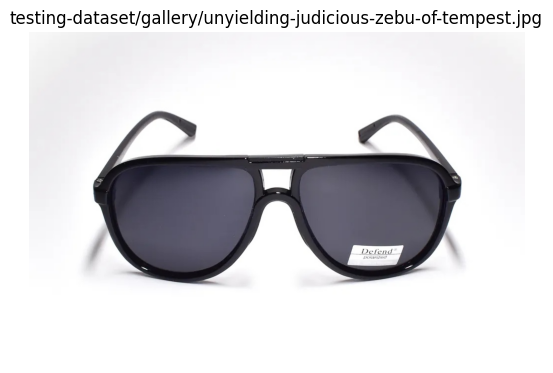

In [8]:
img = view_and_get_info_random_image('testing-dataset/gallery/')

Image shape: (1000, 750, 3)


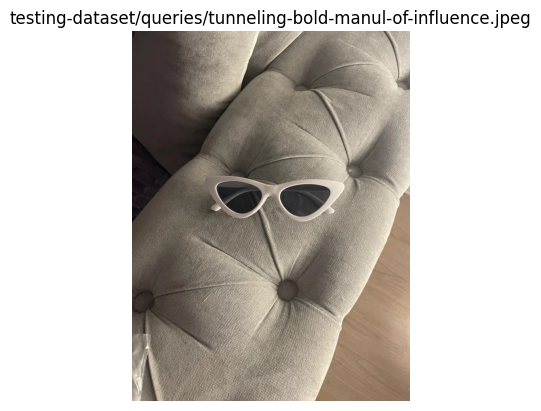

In [9]:
img = view_and_get_info_random_image('testing-dataset/queries/')

In [12]:
def get_query_and_gallery_images_for_a_product_id(product_id):
  """
  This function returns a list of gallery image paths and a list of query
  image paths correcponding to a specific product_id in testing dataset

  Parameters
  ----------
  product_id: integer

  Returns
  -------
  Two list of file paths of gallery and query images corresponding to product_id
  """
  query_images_for_product_id = testing_dataset_queries.loc[testing_dataset_queries['product_id'] == product_id]
  query_image_list = []
  for index, row in query_images_for_product_id.iterrows():
    img_path = row['img_path']
    x = row['bbox_x']
    y = row['bbox_y']
    w = row['bbox_w']
    h = row['bbox_h']
    query_image_list.append(draw_bounding_box_and_save('/content/testing-dataset/' + img_path, x, y, w, h))

  gallery_images_for_product_id = testing_dataset_gallery.loc[testing_dataset_gallery['product_id'] == product_id]
  gallery_image_list = gallery_images_for_product_id['img_path'].tolist()
  print(query_image_list, gallery_image_list)
  return query_image_list, gallery_image_list



def show_query_image_and_gpt_gallery_images(product_id):
  query_imgs, gallery_imgs = get_query_and_gallery_images_for_a_product_id(product_id)
  num_cols = max(len(query_imgs), len(gallery_imgs))
  fig, axis = plt.subplots(2, num_cols, figsize = (10, 6))

  index = 0
  while index < num_cols:
    if len(query_imgs) > index:
      if num_cols > 1:
        axis[0, index].imshow(get_img(query_imgs[index]))
        axis[0, index].axis("off")
      else:
        axis[0].imshow(get_img(query_imgs[index]))
        axis[0].axis("off")
    else:
      axis[0, index].axis("off")
    index = index + 1

  index = 0
  while index < num_cols:
    if len(gallery_imgs) > index:
      if num_cols > 1:
        axis[1, index].imshow(get_img("/content/testing-dataset/" + gallery_imgs[index]))
        axis[1, index].axis("off")
      else:
        axis[1].imshow(get_img("/content/testing-dataset/" + gallery_imgs[index]))
        axis[1].axis("off")
    else:
      axis[1, index].axis("off")
    index = index + 1

  fig.suptitle('product_id=' + str(product_id))
  if num_cols > 1:
    axis[0, 0].set_title('Query Images')
    axis[1, 0].set_title('Gallery Images')
  else:
    axis[0].set_title('Query Images')
    axis[1].set_title('Gallery Images')

  plt.show()

In [13]:
def get_random_product_id():
  product_ids = queries_and_gpt_for_queries['product_id'].tolist()
  return random.sample(product_ids, 1)[0]

def show_query_image_and_gpt_gallery_images_of_random_or_specific_product_id(random=True, product_id=0):
  if random:
    show_query_image_and_gpt_gallery_images(get_random_product_id())
  else:
    show_query_image_and_gpt_gallery_images(product_id)


['/content/temp-imgs/cordial-chowchow-of-sudden-revolution.jpeg', '/content/temp-imgs/excellent-dark-horse-from-ganymede.jpeg', '/content/temp-imgs/analytic-amazing-kittiwake-of-discussion.jpeg'] ['gallery/giga-chameleon-of-authentic-glee.jpg', 'gallery/debonair-shellfish-of-stimulating-sympathy.jpg']


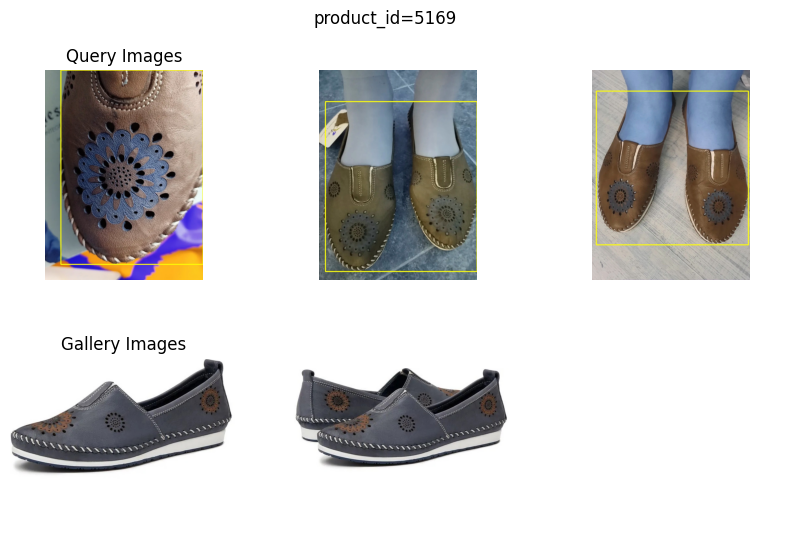

In [28]:
show_query_image_and_gpt_gallery_images_of_random_or_specific_product_id()

In [ ]:
# free up the disk space by deleting the directory 'temp-imgs' used to store the images with bounding box
!rm -rf 'temp-imgs'

In [ ]:
def get_image_shapes_of_gallery_and_query_images():
  query_image_shapes = testing_dataset_queries[['bbox_h', 'bbox_w']]
  query_image_shapes.columns = ['height', 'width']

  list_of_shapes = []
  for gallery_image_path in testing_dataset_gallery['img_path'].tolist():
    list_of_shapes.append((get_img('/content/testing-dataset/' + gallery_image_path)).shape)

  return pd.DataFrame(list_of_shapes, columns=['height', 'width', 'channels']), query_image_shapes

In [ ]:
gallery_image_shapes, query_image_shapes = get_image_shapes_of_gallery_and_query_images()

In [ ]:
gallery_image_shapes.insert(2, "aspect_ratio", np.round(gallery_image_shapes['width'] / gallery_image_shapes['height'], decimals=2), True)
query_image_shapes.insert(2, "aspect_ratio", np.round(query_image_shapes['width'] / query_image_shapes['height'], decimals=2), True)

gallery_image_shapes.drop("channels", axis='columns', inplace=True)

print('gellery.csv images')
display(gallery_image_shapes.head())
print('\nqueries.csv images')
display(query_image_shapes.head())

gellery.csv images


height  width  aspect_ratio
0    1000    750          0.75
1    1000    751          0.75
2    1000   1000          1.00
3     800    800          1.00
4    1000    750          0.75


queries.csv images


height  width  aspect_ratio
0     664    740          1.11
1     378    714          1.89
2     405    395          0.98
3     627    475          0.76
4      81    150          1.85

<Axes: title={'center': 'aspect_ratio(query)'}, ylabel='Density'>

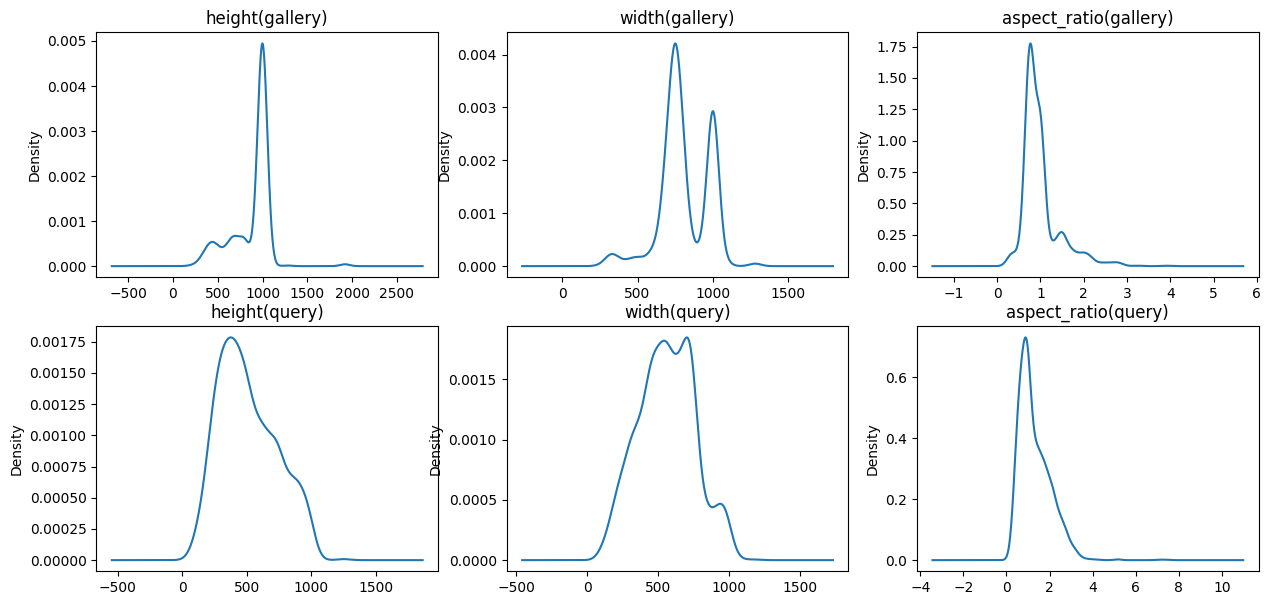

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))

gallery_image_shapes['height'].plot(kind='density', ax=axes[0, 0], title='height(gallery)')
gallery_image_shapes['width'].plot(kind='density', ax=axes[0, 1], title='width(gallery)')
gallery_image_shapes['aspect_ratio'].plot(kind='density', ax=axes[0, 2], title='aspect_ratio(gallery)')

query_image_shapes['height'].plot(kind='density', ax=axes[1, 0], title='height(query)')
query_image_shapes['width'].plot(kind='density', ax=axes[1, 1], title='width(query)')
query_image_shapes['aspect_ratio'].plot(kind='density', ax=axes[1, 2], title='aspect_ratio(query)')

<Axes: title={'center': 'aspect_ratio(pooled)'}, ylabel='Density'>

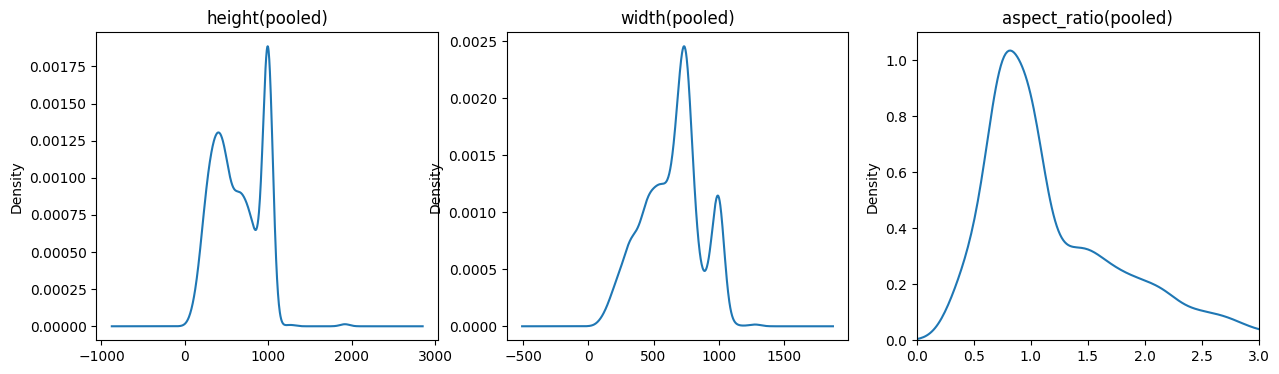

In [ ]:
gallery_query_image_shapes = pd.concat([gallery_image_shapes[['height', 'width', 'aspect_ratio']], query_image_shapes[['height', 'width', 'aspect_ratio']]], axis=0)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
gallery_query_image_shapes['height'].plot(kind='density', ax=axes[0], title='height(pooled)')
gallery_query_image_shapes['width'].plot(kind='density', ax=axes[1], title='width(pooled)')
plt.axis([0, 3, 0, 1.1])
gallery_query_image_shapes['aspect_ratio'].plot(kind='density', ax=axes[2], title='aspect_ratio(pooled)')

In [ ]:
#################################################################
print('galler.csv\n============')
mode = gallery_image_shapes['height'].mode().tolist()
median = gallery_image_shapes['height'].median()
mean = gallery_image_shapes['height'].mean()
print(f'height -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = gallery_image_shapes['width'].mode().tolist()
median = gallery_image_shapes['width'].median()
mean = gallery_image_shapes['width'].mean()
print(f'width -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = gallery_image_shapes['aspect_ratio'].mode().tolist()
median = gallery_image_shapes['aspect_ratio'].median()
mean = gallery_image_shapes['aspect_ratio'].mean()
print(f'aspect_ratio -> mode: {mode}, median: {median}, mean: {np.round(mean, decimals=2)}')
##################################################################
print('\nqueries.csv\n============')
mode = query_image_shapes['height'].mode().tolist()
median = query_image_shapes['height'].median()
mean = query_image_shapes['height'].mean()
print(f'height -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = query_image_shapes['width'].mode().tolist()
median = query_image_shapes['width'].median()
mean = query_image_shapes['width'].mean()
print(f'width -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = query_image_shapes['aspect_ratio'].mode().tolist()
median = query_image_shapes['aspect_ratio'].median()
mean = query_image_shapes['aspect_ratio'].mean()
print(f'aspect_ratio -> mode: {mode}, median: {median}, mean: {np.round(mean, decimals=2)}')
###################################################################
print('\nPooled\n===================')
mode = gallery_query_image_shapes['height'].mode().tolist()
median = gallery_query_image_shapes['height'].median()
mean = gallery_query_image_shapes['height'].mean()
print(f'height -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = gallery_query_image_shapes['width'].mode().tolist()
median = gallery_query_image_shapes['width'].median()
mean = gallery_query_image_shapes['width'].mean()
print(f'width -> mode: {mode}, median: {median}, mean: {np.round(mean)}')

mode = gallery_query_image_shapes['aspect_ratio'].mode().tolist()
median = gallery_query_image_shapes['aspect_ratio'].median()
mean = gallery_query_image_shapes['aspect_ratio'].mean()
print(f'aspect_ratio -> mode: {mode}, median: {median}, mean: {np.round(mean, decimals=2)}')

galler.csv
height -> mode: [1000], median: 1000.0, mean: 882.0
width -> mode: [1000], median: 750.0, mean: 808.0
aspect_ratio -> mode: [0.75], median: 0.83, mean: 1.0

queries.csv
height -> mode: [1000], median: 475.0, mean: 510.0
width -> mode: [750], median: 560.0, mean: 559.0
aspect_ratio -> mode: [0.99], median: 1.09, mean: 1.31

Pooled
height -> mode: [1000], median: 620.0, mean: 642.0
width -> mode: [750], median: 685.0, mean: 648.0
aspect_ratio -> mode: [0.75], median: 1.0, mean: 1.2


In [ ]:
gallery_query_image_shapes.drop(['aspect_ratio'], axis=1, inplace=True)

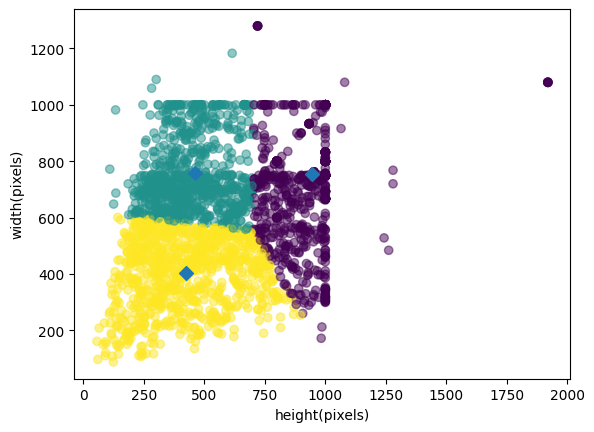

In [ ]:
model = KMeans(n_clusters=3, n_init='auto', random_state=42)

data_points = gallery_query_image_shapes.to_numpy()

model.fit(data_points)

labels = model.predict(data_points)

xs = data_points[:,0]
ys = data_points[:,1]
plt.scatter(xs,ys,c=labels,alpha=0.5)

centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.xlabel('height(pixels)')
plt.ylabel('width(pixels)')
plt.show()

In [ ]:
print(centroids)
print('\nThe corresponding aspect ratios for the centroids are,')
print(centroids[0][0] / centroids[0][1])
print(centroids[1][0] / centroids[1][1])
print(centroids[2][0] / centroids[2][1])

[[943.51129707 753.73807531]
 [462.30425056 756.76845638]
 [422.87185104 402.1456736 ]]

The corresponding aspect ratios for the centroids are,
1.2517760850522406
0.6108926008534453
1.0515389790254275


## Summarization of analysis of datasets

### **Training dataset (Product-10k)**
* Product-10K training dataset is divided into two parts as **train** and **test**.
* An inidividual image of train set has two labels which are **class** and **group**, while an individual image of test set has only the **class** label.
* There are **9691** classes and **360** groups in train set and all the classes are included in the test set too.
* The minimum number of images for a class is **2** and maximum is **81** for train and for the test it is **3** for minimum and **6** for maximum.
* There are total of **141931** entries in train and **55376** entries in test.
* **Class imbalance can be seen clearly on both train and test sets.**
* **The images on both the train and test sets differ from _orientation, image captured perspective and some are surrounded with backgrounds that are not easily distinguishable._**
* **The images of train and test sets does not have a common resolution.**
* **There are no duplicated rows or images used twice**
* **The image sizes can be clustered to 3 clusters where the aspect ration is very close to 1, lower than 1 and higher than 1.**
* **Multiple product categories within the same image in test/9397815.jpg (should be removed)**

The analysis results of image resolution is a follows.*(Since all of the distributions were multi peeked normal distributions, it is concluded that mean value will give a better representation)*

| **_dataset_** | **height(mean)** | **width(mean)** | **aspect ratio(mean)** |
|---------------|------------------|-----------------|------------------------|
| train         | 1114             | 908             | 0.88                   |
| test          | 935              | 844             | 0.94                   |
| pooled        | 1064             | 890             | 0.89                   |

✨**After viewing images belonging to a specific class or a group(randomly) iteratively many times, it is concluded that the images in the train/test sets are almost completely relevent to the given class/group.**

---

### **Testing dataset (by Aicrowd)**
* The testing dataset is divided into **gallery** and the **queries**. The gallery contains the seller images in the e-commerce site while queries contain examples of user queries on the e-commerce site. The images in the queries has the user-defined **bounding box data(bbox_x, bbox_y, bbox_w, bbox_h)**.
* The **product_id** attribute of both the gallery.csv and the queries.csv is used to recongize which gallery images are the GTP(Ground Truth Positives) for a given query with the same product_id.
* Products belonging to **609** classes**(product_id)** are in the gallery and the queries.
* There are total of **1067** entries in gallery and **1935** entries in queries.
* **Through random analysis of galley images, most of the images have distinguishable background and correct orientation although many images differ from captured perspective**
* **The images of train and test sets does not have a common resolution.**
* **There are no duplicated rows or images used twice**
* **The image sizes can be clustered to 3 clusters where the aspect ration is very close to 1, lower than 1 and higher than 1.**

The analysis results of image resolution is a follows.(Since all of the distributions were multi peeked normal distributions, it is concluded that mean value will give a better representation)
- The bounding box height and the width is used as the query image height and width as the area outside of bounding box for a qurey image is mostly non relevent.

| **_dataset_** | **height(mean)** | **width(mean)** | **aspect ratio(mean)** |
|---------------|------------------|-----------------|------------------------|
| gallery       | 882              | 808             | 1.0                    |
| queries       | 510              | 559             | 1.31                   |
| pooled        | 642              | 648             | 1.2                    |


✨**Through random analysis of query images with the relevent GTP gallery images, it is concluded that almost all the query images have a bounding box associated with it that defines the product searched by the user clearly.**


✨**After viewing gallery and query images belonging to random _'product_id'_ iteratively many times, it is concluded that the images in the gallery/query are almost completely relevent to the given _'product_id'_**

## Evaluation Criteria

The evaluation criteria for the whole model is the [**mAP(Mean Average Precision)**](https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52) score.


In [ ]:
def get_average_precision(query_result, GTPs_for_query, num_decimal_places=6):
  """
  This function returns the average precision for a query

  Parameters
  ----------
  query_result: list
      list of the image names in the result in order

  GTPs_for_query: list
      list of GPT image names for the query from the gallery

  Returns
  -------
  The average precision for the query
  """
  indices = []
  for image in GTPs_for_query:
    try:
      index = query_result.index(image)
      indices.append(index + 1)
    except:
      pass
  if len(indices) > 0:
    indices.sort(reverse=True)
    num_of_GPT = len(GTPs_for_query)
    num_of_relevant_images = len(indices)
    average_precision = 0
    for index in indices:
      average_precision = average_precision + (num_of_relevant_images / (index))
      num_of_relevant_images = num_of_relevant_images - 1
    return np.round((average_precision / num_of_GPT), decimals=num_decimal_places)
  return 0

def get_mean_average_precision(average_precisions):
  return np.mean(average_precisions)

## Model

### Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=13824)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(1000, 1000, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.trainable = False
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 1000, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, 1000, 1000, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 1000, 1000, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 500, 500, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 500, 500, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 500, 500, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 250, 250, 128)     0     

In [ ]:
def preprocess_image_by_resizing_and_aligning_to_vgg(image, args):
  """
  This fucntion takes a image and preprocessing parameters(resizing_method,
  target_size) as input and output resized, preporcessed image to align the
  images in the dataset which vgg16 or vgg19 was trained on

  Parameters
  ----------
  image: array
      numpy array of the image

  args: dictionary
      {resizing_method: 'resize_with_pad' or 'resize_with_crop_or_pad'
      target size: (h, w)}

  Returns
  -------
  A tensor of the preprocessed input image
  """
  assert args is not None
  assert args.get('resizing_method') is not None
  assert args.get('target_size') is not None
  resized_image = None
  resizing_method = args['resizing_method']
  target_size = args['target_size']
  if resizing_method == 'resize_with_pad':
    resized_image = tf.image.resize_with_pad(image, target_size[0], target_size[1])
  elif resizing_method == 'resize_with_crop_or_pad':
    resized_image = tf.image.resize_with_crop_or_pad(image, target_size[0], target_size[1])
  else:
    raise Exception('No valid resizing method provided')
  return preprocess_input(resized_image)

def batch_of_images_to_tensor(dataset, batch_size=None, num_prev_batches=0, preprocess_function=None, preprocess_args=None):
  """
  This function is used to create a tensor containing resized and preprocessed
  batch of images

  Paramters
  ---------
  dataset: pandas dataframe
      The dataframe must have two columns, one named 'img_path' containing the
      full path of the image and 'img_name' containing the image file name within
      the folder

  batch_size: integer or None
      The maximum number of images a tensor should contain

  num_prev_batches: integer
      The number of batches made from the dataset prviously. used to
      determine the starting point for the new batch

  preprocess_function: function
      The funtion for preprocessing the images before turning to tensors

  preprocess_args: dictionary(eg: - {target_size: (800, 800), resize_method: 'resize_with_pad'})
      The necessary arguments to the preprocessing function

  Returns
  -------
  The tensor and the num_prev_batches, None if no more images to make tensors
  """
  tensor = None
  batch_dataset = None
  if batch_size == None:
    batch_dataset = dataset
  else:
    start_index = num_prev_batches * batch_size
    end_index = start_index + batch_size
    max_index = dataset.tail(1).index[0]
    if start_index > max_index:
      return None
    if end_index < max_index:
      batch_dataset = dataset.iloc[start_index:end_index]
    else:
      batch_dataset = dataset.iloc[start_index:]

  first_image = True
  for index, row in batch_dataset.iterrows():
    image_file = tf.io.read_file(row['img_path'])
    image = tf.image.decode_image(image_file)
    if preprocess_function is not None:
      image = preprocess_function(image, preprocess_args)
    if first_image:
      tensor = tf.expand_dims(image, axis=0)
      first_image = False
    else:
      tensor = tf.concat([tensor, tf.expand_dims(image, axis=0)], 0)
  return tensor, num_prev_batches + 1


def get_feature_map_tensor_from_pretrained_vgg_model(vgg_model, input_tensor):
  """
  This function takes in the vgg_model(vgg16 or vgg19) and input_tensor and
  predict the output tensor(feature maps of the input image tensors)

  Parameters
  ----------
  vgg_mode: vgg16 or vgg19 model object

  input_tensor: tensor
      tensor of a one image or a batch of images which are
      resized and preprocessed

  Return
  ------
  The predicted tensor(feature maps) for the input tensor
  """
  return vgg_model.predict(input_tensor)


def save_tensor_as_file(tensor, folder_path, file_name, batch=None):
  """
  This function save a tensor in a file(permanent storage)

  Parameters
  ----------
  tensor: tensor
      tensor to be saved in a file

  folder_path: string
      the path of the folder where the tensor file should be stored

  file_name: string
      the name of the file

  batch: integer
      batch number if exists

  Returns
  -------
  None
  """
  tensor_string = tf.io.serialize_tensor(tensor)
  file_path = ""
  if batch is not None:
    file_path = folder_path + '/' + file_name + '_' + str(batch) + '.tf'
  else:
    file_path = folder_path + '/' + file_name + '.tf'
  tf.io.write_file(file_path, tensor_string)

def get_tensor_from_file(file_path, datatype):
  """
  This function recreate the tensor stored in a file

  Parameters
  ----------
  file_path: string
      The full file path of the file that stores the tensor

  datatype: <tensorflow.dtype>
      eg:- tf.int32, tf.uint8, tf.float32

  Return
  ------
  The tensor with in the file
  """
  tensor_string = tf.io.read_file(file_path)
  return tf.io.parse_tensor(tensor_string, out_type=datatype)

In [ ]:
import pandas as pd
gallery = pd.read_csv('/content/testing-dataset/gallery.csv', low_memory=False)
gallery['img_name'] = gallery['img_path'].apply(lambda x: str(x).split('/')[1])
gallery['img_path'] = gallery['img_path'].apply(lambda x: '/content/testing-dataset/' + str(x))
gallery.drop(['seller_img_id', 'product_id'], axis=1, inplace=True)

tensor, num_batch = batch_of_images_to_tensor(gallery, batch_size=16, num_prev_batches=0,
                          preprocess_function=preprocess_image_by_resizing_and_aligning_to_vgg,
                          preprocess_args={'resizing_method': 'resize_with_pad', 'target_size':(1000, 1000)})

In [ ]:
print(tensor.shape)

predicted = get_feature_map_tensor_from_pretrained_vgg_model(vgg16, tensor)
print(predicted.shape)


(16, 1000, 1000, 3)
1/1 [==============================] - 36s 36s/step
(16, 31, 31, 512)


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
print(tensor.shape)
print(tensor.dtype)

(8, 1000, 1000, 3)
<dtype: 'float32'>


In [ ]:
save_tensor_as_file(tensor, '/content/gallery-tensors/', 'batch', 1)

In [ ]:
a = get_tensor_from_file('/content/gallery-tensors/batch_1.tf', tf.float32)

In [ ]:
a.shape

TensorShape([8, 1000, 1000, 3])

In [ ]:
!nvidia-smi

Fri Aug 18 09:22:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gc
gc.collect()

4083

In [ ]:
def store_feature_maps():
  image = get_img('/content/training-dataset/train/1.jpg')
  print(image.shape)
  image = tf.image.resize_with_pad(image, 800, 800)
  print(image.shape)
  image = preprocess_input(image)
  print(image.shape)
  image = np.expand_dims(image, axis=0)
  print(image.shape)
  prediction = vgg16.predict(image)
  return prediction

x = store_feature_maps()
print(x.shape)
print(x)